# 3. Linear Models for Regression

original work by ctgk

https://github.com/ctgk/PRML/blob/master/notebooks/ch03_Linear_Models_for_Regression.ipynb

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from prml.features import GaussianFeatures, PolynomialFeatures, SigmoidalFeatures

In [10]:
from prml.linear import (
    LinearRegressor,
)

In [5]:
np.random.seed(1234)

In [6]:
def create_toy_data(func, sample_size, std, domain=[0,1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

## 3.1 Linear Basis Function Models

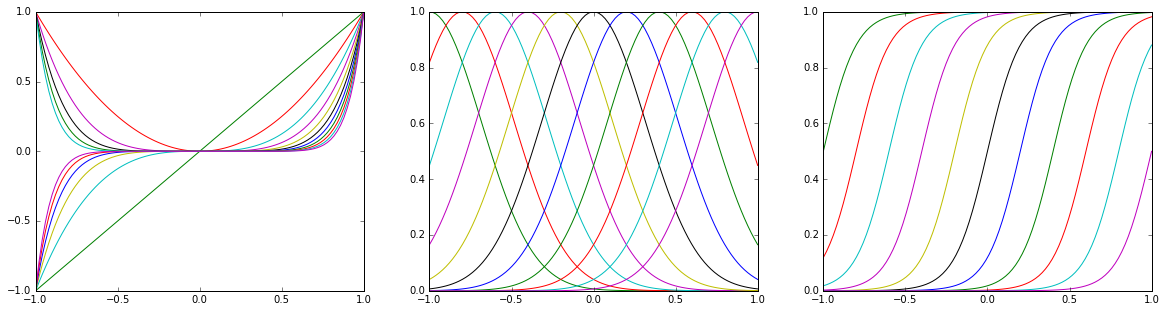

In [7]:
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeatures(degree=11).transform(x[:, None])
X_gaussian = GaussianFeatures(mean=np.linspace(-1,1, 11), var=0.1).transform(x)
X_sigmoidal = SigmoidalFeatures(mean=np.linspace(-1,1,11), coef=10).transform(x)

plt.figure(figsize=(20, 5))
for i, X, in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i+1)
    for j in range(12):
        plt.plot(x, X[:,j])

### 3.1.1 Maximum likelihood and least squares

In [13]:
def sinusoidal(x):
    return np.sin(2*np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, sample_size=100, std=0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

In [9]:
# select one of the three features below
# feature = PolynomialFeatures(degree=8)
feature = GaussianFeatures(mean=np.linspace(0, 1, 8), var=0.1)
# feature = SigmoidalFeatures(mean=np.linspace(0, 1, 8), coef=10)

In [11]:
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegressor()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, return_std=True)

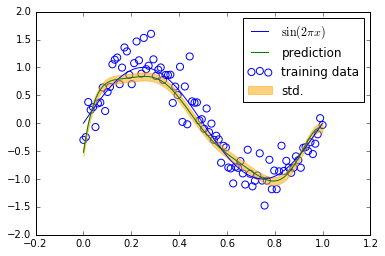

In [14]:
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std,
                color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()